# cs8321 Lab 1 - ConceptNet Ethics Testing

#### Chip Henderson - 48996654 


In [1]:
# Import everything
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Modeling

I'm going to be using the same ConveptNet Numberbatch embedding files that were used in the in-class notebook example. I'm working from a Microsoft Surface Pro 8 for most of this lab so I'm somewhat resource limited. So I'm going to be using a 50 sized embedding parameter.

In [3]:
%%time

# Source: modified from course notebook "ConceptNet"
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

# embeddings = load_embeddings('data/glove.840B.300d.txt')
embeddings = load_embeddings('../Data_Sources/glove.840B.300d.txt') # altered for my system
embeddings.shape

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

NameError: name 'embedding_matrix' is not defined

: 

In [42]:
# Source: Modified from in-class notebook 13a
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TWEET_LEN,
                            trainable=False)

#### Convolutional Neural Network 1 (CNN-1)

The first CNN I'll run will consist of 64 filters with a width of 5. I'm changing the filter size from the in-class example because my dataset is quite a bit smaller. So my thought being I won't need so many filters to get good results.

In [43]:
# Source: Modified from in-class lecture, notebook 13a
from tensorflow.keras.metrics import Precision

EMBED_SIZE = 50  # same size as loaded from GLOVE
NUM_CLASSES = 3
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 500
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 500-4=496
x = MaxPooling1D(5)(x) # after max pool, 996/5 = 99
x = Dropout(0.2)(x) # after dropout, size is 95
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
x = MaxPooling1D(5)(x) # this is the size to globally flatten, 15/5 = 3
# flattened vector max pools across each of the 3 elements
# so vectors is now 192 dimensions 3*64 = 192
x = Flatten()(x)

x = Dropout(0.2)(x)
x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_cnn_1 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_cnn_1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['Precision'])

print(model_cnn_1.summary())

cnn1_histories = []
tmp = model_cnn_1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=30, batch_size=128)
cnn1_histories.append(tmp)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           3050000   
                                                                 
 conv1d (Conv1D)             (None, 496, 64)           16064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 95, 64)            20544     
                                                             

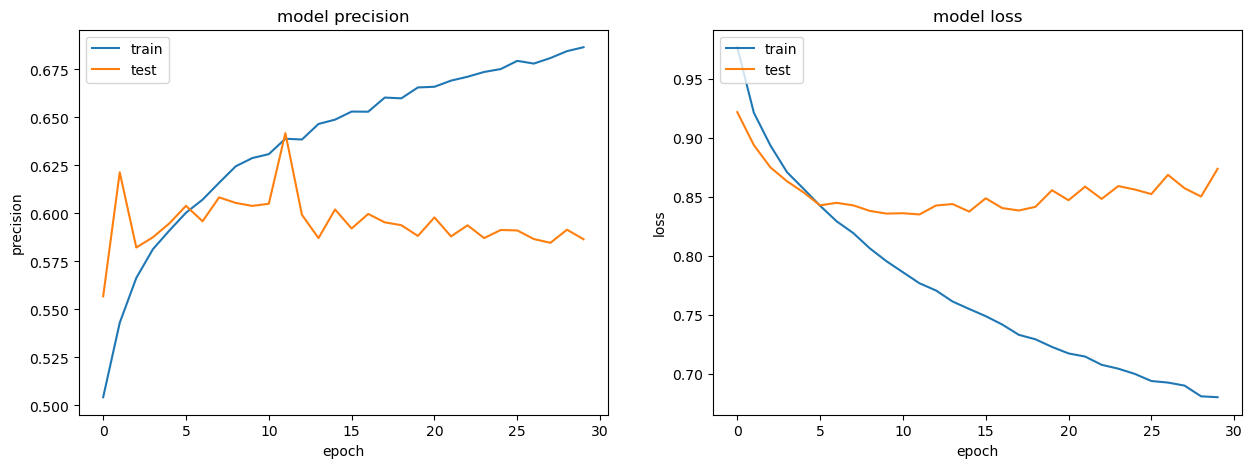

In [150]:
# Source: in class lecture notebook 13a
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in cnn1_histories])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

These results aren't looking great to me. I never really improve my validation precision values across 30 epochs. Also, pretty minimal minimization of my loss function. I had one peak value around 63% on validation precision but not much more than that.

#### Convolutional Neural Network 2 (CNN-2)

For this CNN I'm going to see if the example from the in-class notebook which used 128 filters will hinder or help my model. Because Tweets are relatively short and I've already removed stopwords, I initially tried making my filters narrower with a width of 3. The results were very poor, so I reverted to the filter width of 5 used in my previous model. Finally, I'm also changing my optimizer to 'Adam'. 

In [59]:
# Source: in class lecture notebook 13a

EMBED_SIZE = 50  # same size as loaded from GLOVE
NUM_CLASSES = 3
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 500
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu', # changed to 64 from 128
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(5)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.1)(x) # cut final drop out in half
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_cnn_2 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_cnn_2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['Precision'])

print(model_cnn_2.summary())

cnn2_histories = []
tmp = model_cnn_2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=15, batch_size=128)
cnn2_histories.append(tmp)

"\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense\nfrom tensorflow.keras.layers import Dense, Input, Dropout\nfrom tensorflow.keras.layers import Embedding\n\nEMBED_SIZE = 50  # same size as loaded from GLOVE\nNUM_CLASSES = 3\nsequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')\n# starting size: 500\nembedded_sequences = embedding_layer(sequence_input) # from previous embedding\nx = Conv1D(128, 5, activation='relu', # changed to 64 from 128\n           kernel_initializer='he_uniform')(embedded_sequences)\n\n# after conv, size becomes: 1000-4=996\nx = MaxPooling1D(5)(x)# after max pool, 996/5 = 199\nx = Dropout(0.2)(x)\nx = Conv1D(128, 5, activation='relu',\n           kernel_initializer='he_uniform')(x)\n\n# new size is 195\nx = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39\nx = Dropout(0.2)(x)\nx = Conv1D(128, 5, activation='relu',\n           kernel_initializer='he_uniform')(x)\n\n# after convolu

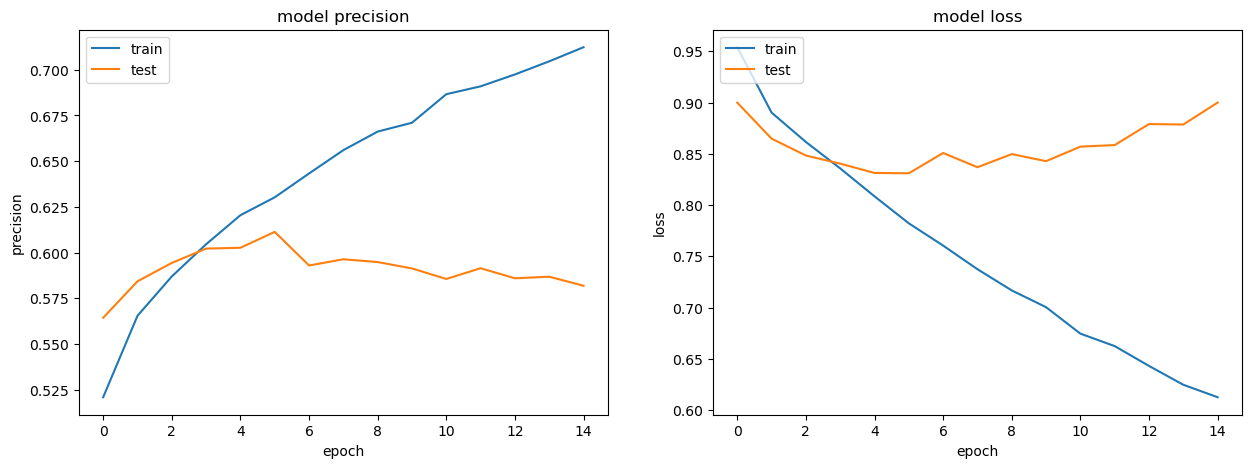

In [51]:
# Source: in class lecture notebook 13a
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in cnn2_histories])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, these results aren't great. I start to overfit much faster with this model at roughly 8 or 9 epochs. Also my validation precision is a little more stable than the first model, but doesn't get as high. Comparting the two visually there is little to no difference.

#### CNN 2 with Varaince Pooling

I'm going to try a model that utilizes variance pooling next to see if that improves my performance at all. I would expect this might help things as it is an extra feature by which to train on the data.

In [60]:
# Source: Modified from in class notebook 13a

EMBED_SIZE = 50  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])


x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xvec = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['Precision'])

print(model_xvec.summary())

model_xvec_histories = []
tmp = model_xvec.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
model_xvec_histories.append(tmp)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 50)      3050000     ['input_9[0][0]']                
                                                                                                  
 conv1d_24 (Conv1D)             (None, 496, 64)      16064       ['embedding[8][0]']              
                                                                                                  
 max_pooling1d_20 (MaxPooling1D  (None, 99, 64)      0           ['conv1d_24[0][0]']              
 )                                                                                          

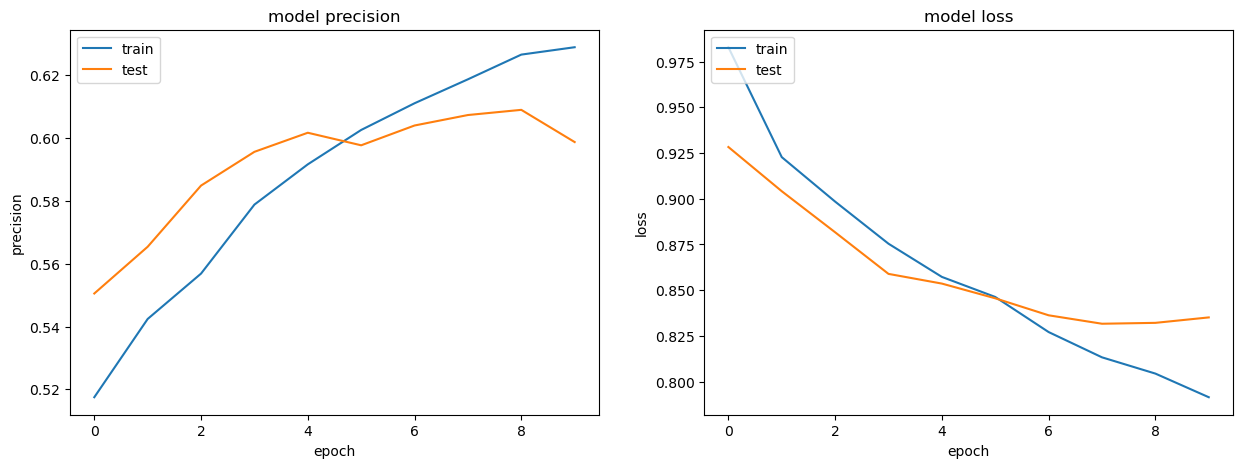

In [61]:
# Source: in class lecture notebook 13a
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in model_xvec_histories])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I'm seeing a little bit more of what I would have expected from a visual perspective with this model. I have general improvement in validation precision over the epochs until the model converges around 8 epochs, then I have a decline. However these values really aren't any better than what I saw out of my first two models.

Overall for my CNNs the results are dissapointing. I'd like to see much higher precision in order to say that this model is a viable recommender. I'll move on to transformers next.

#### Transformer 1 (xformer-1)

In [85]:
# Source: In-class notebook 13a

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [86]:

# Source: In-class lecture notebook 13a
# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding

class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TWEET_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_TWEET_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_TWEET_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [87]:
# Source: Modified from in-class lecture notebook 13a

num_heads = 2  # Number of attention heads, trying 2 to start
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
NUM_CLASSES = 3

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer1 = Model(inputs=inputs, outputs=preds)
print(model_xformer1.summary())

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 500)]             0         
                                                                 
 glove_token_and_position_em  (None, 500, 50)          3075000   
 bedding (GloveTokenAndPosit                                     
 ionEmbedding)                                                   
                                                                 
 transformer_block_6 (Transf  (None, 500, 50)          23832     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_16  (None, 50)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_53 (Dropout)        (None, 50)                0  

In [88]:
# Source: modified from in-class lecture notebook 13a
model_xformer1.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer1 = []
tmp = model_xformer1.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=128) # Changed batch size from 16 to 128
histories_xformer1.append(tmp)

Epoch 1/6


281/281 [==============================] - 456s 2s/step - loss: 0.8010 - precision: 0.7293 - val_loss: 0.6630 - val_precision: 0.7813
Epoch 2/6
281/281 [==============================] - 449s 2s/step - loss: 0.6668 - precision: 0.7732 - val_loss: 0.6436 - val_precision: 0.7531
Epoch 3/6
281/281 [==============================] - 450s 2s/step - loss: 0.6437 - precision: 0.7789 - val_loss: 0.6142 - val_precision: 0.7923
Epoch 4/6
281/281 [==============================] - 448s 2s/step - loss: 0.6255 - precision: 0.7848 - val_loss: 0.6030 - val_precision: 0.7978
Epoch 5/6
281/281 [==============================] - 443s 2s/step - loss: 0.6157 - precision: 0.7913 - val_loss: 0.6005 - val_precision: 0.7784
Epoch 6/6
281/281 [==============================] - 431s 2s/step - loss: 0.6089 - precision: 0.7948 - val_loss: 0.5948 - val_precision: 0.7892


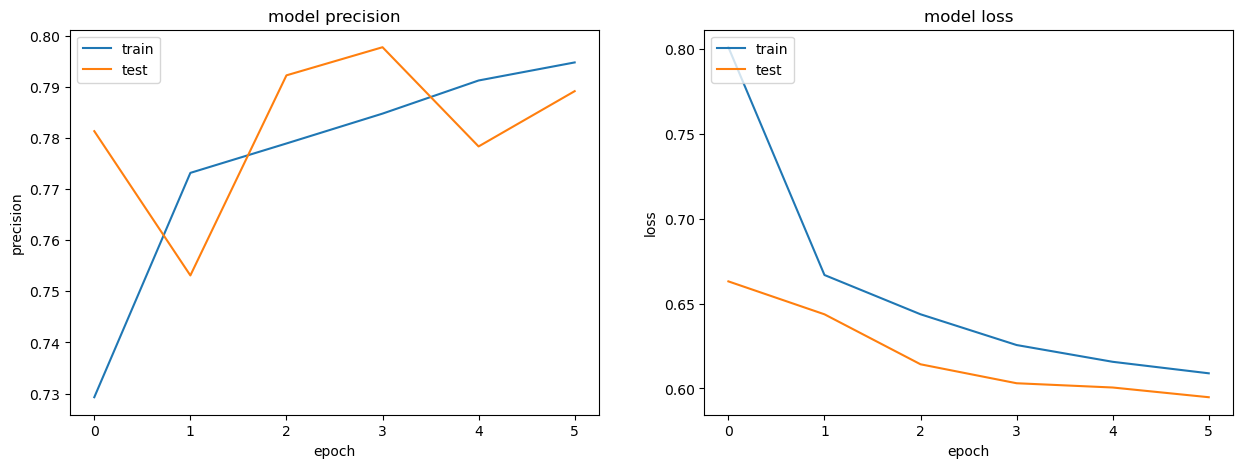

In [89]:
%matplotlib inline
# Source: in class lecture notebook 13a
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer1])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here, I noted that my model had not fully converged. Therefore I trained for another 2 epochs.

In [92]:
tmp = model_xformer1.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer1.append(tmp)

Epoch 1/2
281/281 [==============================] - 437s 2s/step - loss: 0.6045 - precision: 0.7937 - val_loss: 0.5952 - val_precision: 0.7907
Epoch 2/2
281/281 [==============================] - 434s 2s/step - loss: 0.6005 - precision: 0.7975 - val_loss: 0.5928 - val_precision: 0.7850


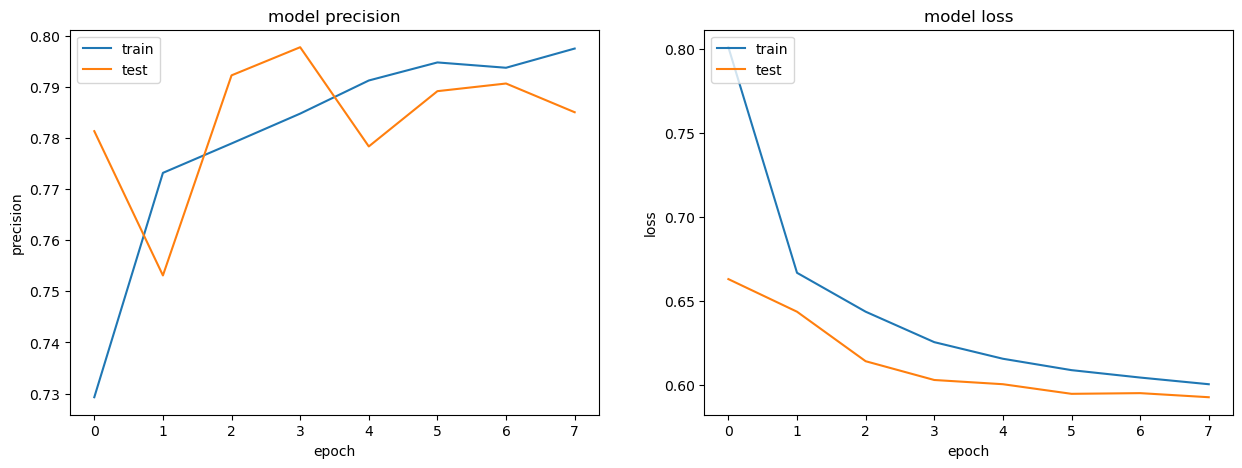

In [118]:
%matplotlib inline
# Source: in class lecture notebook 13a

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer1])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now I'm seeing the characteristics I would to tell me my model is converged. I have a flattening of the validation loss as well as relatively flat performnace of model precision on the validation data.

#### Transformer 2 (xformer-2)

For transformer 2 I decided to increase the number of attention heads from 2 to 4 to see if that aided performance. I expect this will probably take longer to train as this will increase the number of trainable parameters. I noted after the first epochs that additional runs were required to achieve convergence. For the sake of brevity I removed the charting per each step and just left the final one.

In [107]:
# Source: in class lecture notebook 13a
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer2 = Model(inputs=inputs, outputs=preds)
print(model_xformer2.summary())

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 500)]             0         
                                                                 
 glove_token_and_position_em  (None, 500, 50)          3075000   
 bedding_4 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_12 (Trans  (None, 500, 50)          44132     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_20  (None, 50)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_73 (Dropout)        (None, 50)                0  

In [108]:
histories_xformer2 = []

# Source: modified from in-class lecture notebook 13a
model_xformer2.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer2 = []
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

Epoch 1/6


281/281 [==============================] - 855s 3s/step - loss: 0.7973 - precision: 0.7282 - val_loss: 0.6517 - val_precision: 0.7731
Epoch 2/6
281/281 [==============================] - 841s 3s/step - loss: 0.6609 - precision: 0.7724 - val_loss: 0.6429 - val_precision: 0.7606
Epoch 3/6
281/281 [==============================] - 835s 3s/step - loss: 0.6358 - precision: 0.7803 - val_loss: 0.6124 - val_precision: 0.7863
Epoch 4/6
281/281 [==============================] - 835s 3s/step - loss: 0.6189 - precision: 0.7857 - val_loss: 0.6025 - val_precision: 0.7757
Epoch 5/6
281/281 [==============================] - 835s 3s/step - loss: 0.6092 - precision: 0.7898 - val_loss: 0.5955 - val_precision: 0.7876
Epoch 6/6
281/281 [==============================] - 846s 3s/step - loss: 0.6024 - precision: 0.7938 - val_loss: 0.5869 - val_precision: 0.8173


The model had not converged after 6 epochs, I continued to run for 2 epochs checking for convergence before finally getting there after 12 total.

In [112]:
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

Epoch 1/2
281/281 [==============================] - 866s 3s/step - loss: 0.5958 - precision: 0.7971 - val_loss: 0.5797 - val_precision: 0.8115
Epoch 2/2
281/281 [==============================] - 843s 3s/step - loss: 0.5873 - precision: 0.7999 - val_loss: 0.5765 - val_precision: 0.7991


In [114]:
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer2])
    


Epoch 1/2
281/281 [==============================] - 847s 3s/step - loss: 0.5780 - precision: 0.7999 - val_loss: 0.5765 - val_precision: 0.7922
Epoch 2/2
281/281 [==============================] - 864s 3s/step - loss: 0.5725 - precision: 0.8058 - val_loss: 0.5674 - val_precision: 0.7925


In [116]:
tmp = model_xformer2.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer2.append(tmp)

Epoch 1/2
281/281 [==============================] - 946s 3s/step - loss: 0.5685 - precision: 0.8049 - val_loss: 0.5617 - val_precision: 0.8065
Epoch 2/2
281/281 [==============================] - 862s 3s/step - loss: 0.5614 - precision: 0.8104 - val_loss: 0.5657 - val_precision: 0.7881


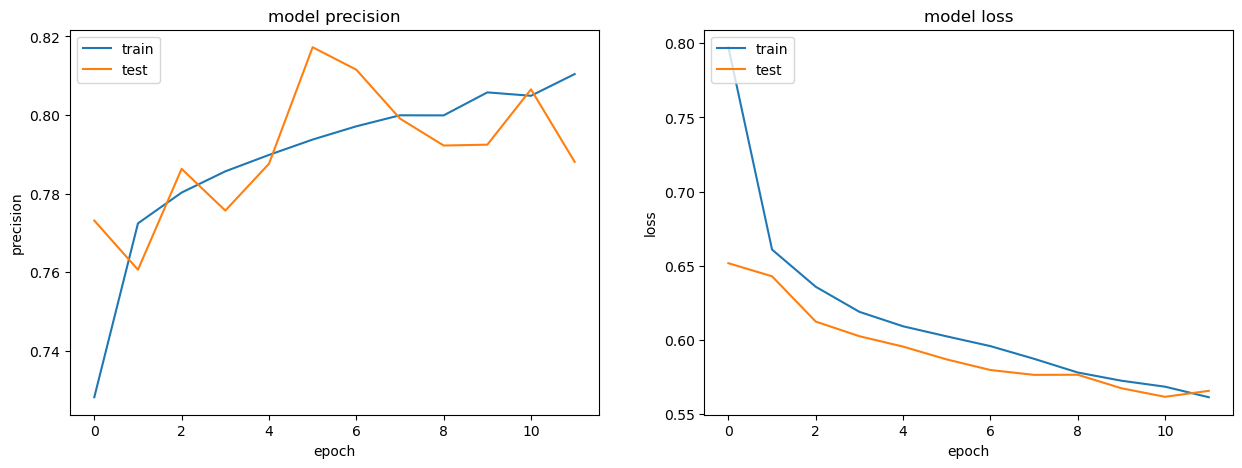

In [117]:
# Source: in class lecture notebook 13a
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer2])

# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

After 12 epochs I feel comfortable saying my model has probably converged. I can see a general decline in the test precision and the first uptick on the validation loss.

#### Transformer with Extra Layer (xformer-XL)

Per lab requirements, I have added an extra layer to the 4 attention head transformer used previously. As with my previous model, reaching convergence took more epochs than I expected. I again have removed the charting I did after each training for the sake of brevity, keeping the final one.

In [93]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x) # Extra layer added


x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer_xl = Model(inputs=inputs, outputs=preds)
print(model_xformer_xl.summary())

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 500)]             0         
                                                                 
 glove_token_and_position_em  (None, 500, 50)          3075000   
 bedding_2 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_9 (Transf  (None, 500, 50)          44132     
 ormerBlock)                                                     
                                                                 
 transformer_block_10 (Trans  (None, 500, 50)          44132     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_18  (None, 50)               0  

In [94]:
# Source: modified from in-class lecture notebook 13a
model_xformer_xl.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer_xl = []
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/6


281/281 [==============================] - 1614s 6s/step - loss: 0.8018 - precision: 0.7366 - val_loss: 0.6527 - val_precision: 0.7886
Epoch 2/6
281/281 [==============================] - 1652s 6s/step - loss: 0.6629 - precision: 0.7758 - val_loss: 0.6312 - val_precision: 0.7676
Epoch 3/6
281/281 [==============================] - 1650s 6s/step - loss: 0.6378 - precision: 0.7813 - val_loss: 0.6090 - val_precision: 0.7845
Epoch 4/6
281/281 [==============================] - 1649s 6s/step - loss: 0.6216 - precision: 0.7883 - val_loss: 0.6042 - val_precision: 0.7787
Epoch 5/6
281/281 [==============================] - 1643s 6s/step - loss: 0.6047 - precision: 0.7914 - val_loss: 0.5795 - val_precision: 0.7970
Epoch 6/6
281/281 [==============================] - 1638s 6s/step - loss: 0.5869 - precision: 0.7973 - val_loss: 0.5794 - val_precision: 0.7851


In [97]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1650s 6s/step - loss: 0.5770 - precision: 0.8029 - val_loss: 0.5652 - val_precision: 0.7971
Epoch 2/2
281/281 [==============================] - 1651s 6s/step - loss: 0.5625 - precision: 0.8086 - val_loss: 0.5576 - val_precision: 0.8035


In [99]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1651s 6s/step - loss: 0.5543 - precision: 0.8103 - val_loss: 0.5519 - val_precision: 0.8015
Epoch 2/2
281/281 [==============================] - 1627s 6s/step - loss: 0.5485 - precision: 0.8128 - val_loss: 0.5476 - val_precision: 0.8138


In [101]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1665s 6s/step - loss: 0.5421 - precision: 0.8172 - val_loss: 0.5701 - val_precision: 0.7942
Epoch 2/2
281/281 [==============================] - 1648s 6s/step - loss: 0.5347 - precision: 0.8188 - val_loss: 0.5435 - val_precision: 0.8070


In [103]:
tmp = model_xformer_xl.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_xl.append(tmp)

Epoch 1/2
281/281 [==============================] - 1650s 6s/step - loss: 0.5274 - precision: 0.8218 - val_loss: 0.5374 - val_precision: 0.8035
Epoch 2/2
281/281 [==============================] - 1647s 6s/step - loss: 0.5215 - precision: 0.8247 - val_loss: 0.5409 - val_precision: 0.8056


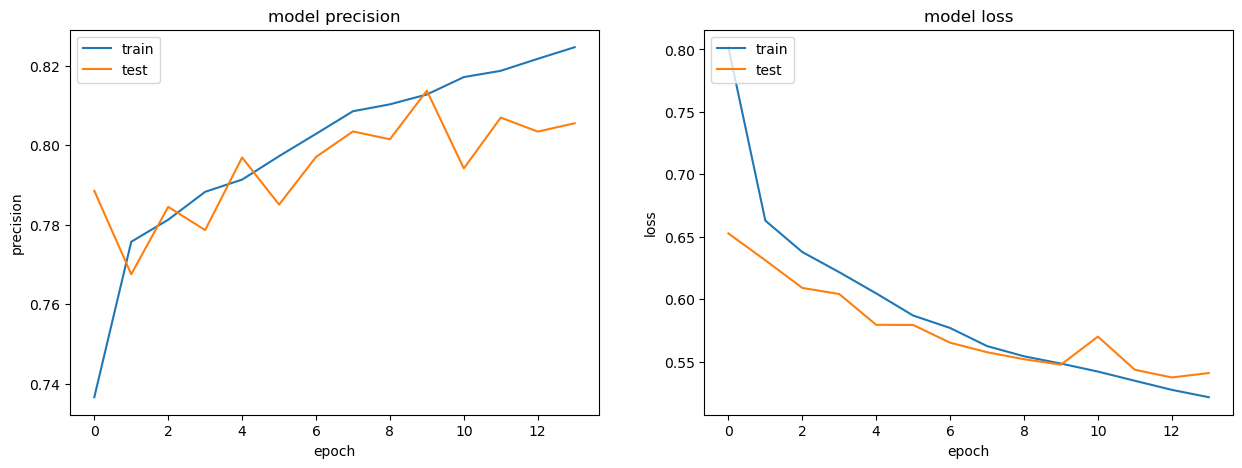

In [104]:
%matplotlib inline
# Source: in class lecture notebook 13a

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_xl])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here I can see again what appears to be convergence, this time after 14 epochs.

#### Comparison of the models

To determine best performance of the models I had trained, I needed to pull all the results together and perform a statistical analysis. I'll start by aligning all of my plotted visuals into a more concise presentation.

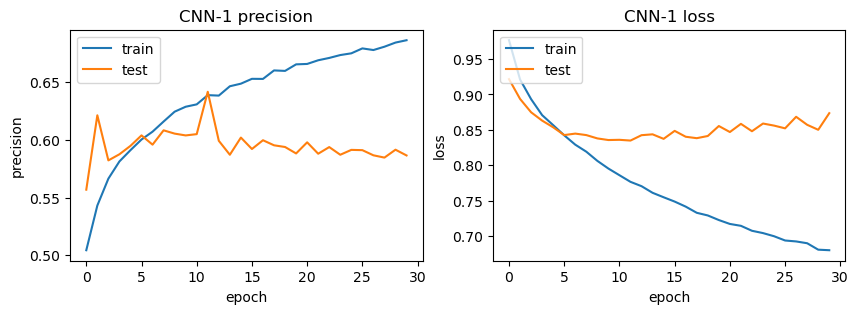

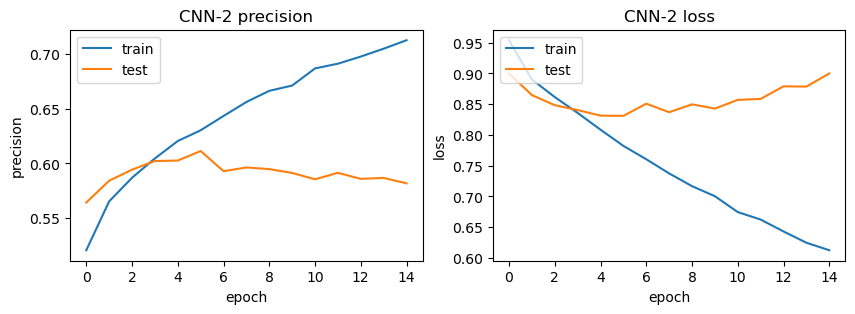

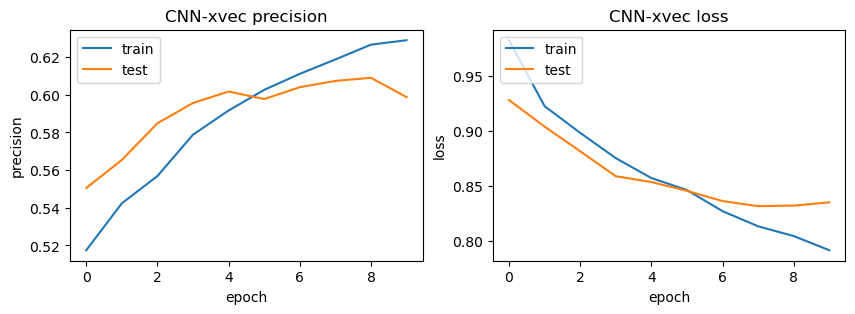

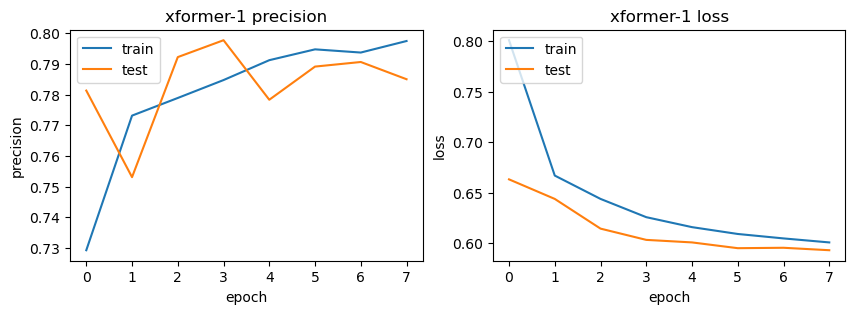

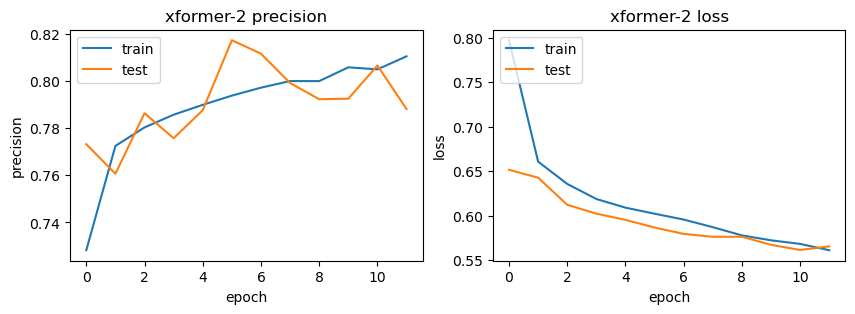

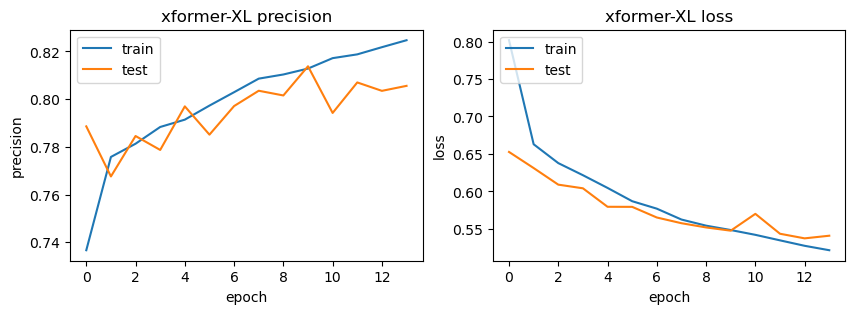

"\n# combine all the history from the second CNN training together\ncombined = dict()\nfor key in ['precision','val_precision','loss','val_loss']:\n    combined[key] = np.hstack([x.history[key] for x in cnn2_histories])\n    \n# summarize history for precision\nplt.figure(figsize=(10,3))\nplt.subplot(121)\nplt.plot(combined['precision'])\nplt.plot(combined['val_precision'])\nplt.title('CNN 2 precision')\nplt.ylabel('precision')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\n\n# summarize history for loss\nplt.subplot(122)\nplt.plot(combined['loss'])\nplt.plot(combined['val_loss'])\nplt.title('CNN 2 loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\n# plt.show()\n\n\n# combine all the history from transformer 1 training together\ncombined = dict()\nfor key in ['precision','val_precision','loss','val_loss']:\n    combined[key] = np.hstack([x.history[key] for x in histories_xformer1])\n    \n# summarize history for pre

In [174]:
# Source: modified from in class lecture, notebook 13a
%matplotlib inline

# Add a list variable to loop through each result
histories = [cnn1_histories, 
             cnn2_histories, 
             model_xvec_histories,
             histories_xformer1, 
             histories_xformer2,
             histories_xformer_xl
             ]

# Add a list variable to hold model names so we can tell which is which in the charts
model_names = ['CNN-1',
               'CNN-2',
               'CNN-xvec',
               'xformer-1',
               'xformer-2',
               'xformer-XL'
               ]

for i in range(6):
    # combine all the history from the first CNN training together
    combined = dict()
    for key in ['precision','val_precision','loss','val_loss']:
        combined[key] = np.hstack([x.history[key] for x in histories[i]])
        
    # summarize history for precision
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(combined['precision'])
    plt.plot(combined['val_precision'])
    plt.title(f'{model_names[i]} precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title(f'{model_names[i]} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

A visual comparison of my models shows the transformers performed much better than the convolutional neural networks (CNN) for this particular dataset and purpose. I consistently hit precision values near or over 80% with the transformers while the CNNs never got above 65%. Further, my models began to overfit very quickly with the CNNs. I may have been able to address this with more aggressive dropout, however my transformers did not have similar issues.

Specifically comparing my three CNNs, it appears my hypothesis that Tweets being shorter in length not needing so many filters is at least to some extent correct. I saw higher spikes in validation precision when using 64 filters in CNN1 instead of 128 filters in CNN2. I will say that overall these two models performed comparably. CNN2 appears a bit more stable in its precision values. CNN2 appears to show signs of overfitting quite a bit faster than CNN1. I repeated CNN1 and adding variance pooling for the model CNN-xvec, however this also appears to not really have helped my model performance overall.

The transformers performed comparably as well. I was able to get a little more performance out of xformer-2 which tells me that the additional 2 attention heads did get me better peak precision. On average though the values are fairly close. With each increase in complexity, the number of epochs required to reach convergence increased. The xformer with the extral layer took the longest to train and the most epochs to converge. The extra layer did not appear to have directly helped the precision values, at least visually. It never got about 82% while I did see near that value out of xformer-2.

In [171]:
# Compare max precision values from all the models
prec_vals = []
for i in range(5):
    for items in histories[i]:
        prec_vals.append((max(items.history.get('val_precision'))))
    print(f'The max validation precision in {model_names[i]} is {max(prec_vals)}')
    prec_vals = []


The max validation precision in CNN-1 is 0.6418331861495972
The max validation precision in CNN-2 is 0.611295223236084
The max validation precision in xformer-1 is 0.7977653741836548
The max validation precision in xformer-2 is 0.8172522783279419
The max validation precision in xformer-XL is 0.813759446144104


Generally, I can see that transformer model 2 gave me the best peak validation precision and this confirms my transformer models performed best overall.

To be confident which model was best I need to determine whether they are truly statistically different from one another. I won't be comparing my CNNs because I can tell from the previous data their performance was below that of the transformers.

In [181]:
### Transformer 1 vs Transformer 2 ###
# Modeified from lab 5 and in-class lecture to use precision
from scipy.stats import t

xf1_combined = []
xf2_combined = []

# Get the histories of recall scores from my two models for comparison
# recall_arch1_mod1 = histories_xformer1.history['val_precision']
# recall_arch1_mod2 = histories_xformer2.history['val_precision']
# for key in ['precision','val_precision','loss','val_loss']:
xf1_combined = np.hstack([x.history['val_precision'] for x in histories_xformer1])
xf2_combined = np.hstack([x.history['val_precision'] for x in histories_xformer2])

# get error rates for both model's recall scores
xf1_err = [1 - prec for prec in xf1_combined]
xf2_err = [1 - prec for prec in xf2_combined]

d = []
for err in range(len(xf1_err)):
    d.append(xf1_err[err] - xf2_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 30
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the first architecture')

Range of: -0.026171336796715766 0.037060807373955756 between the two models in the first architecture


This range contains 0. So, I can say with 95% confident these two models are NOT statistically different from one another. Because they are not statistically different, I'll take the best peak precision model which was transformer 2, and compare that to my third model which had the extra layer in it.

In [183]:
### Transformer 2 vs Transformer with the extra layer ###
# Modeified from lab 5 and in-class lecture to use precision
from scipy.stats import t

xfxl_combined = []

# Just need combined history from the new model
xfxl_combined = np.hstack([x.history['val_precision'] for x in histories_xformer_xl])

# get error rates for new model's val_precision scores
xfxl_err = [1 - prec for prec in xfxl_combined]

d = []
for err in range(len(xf2_err)):
    d.append(xfxl_err[err] - xf2_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 30
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the first architecture')

Range of: -0.032574091516493035 0.02792524711545137 between the two models in the first architecture


This range does not contain 0. Therefore, I can say with 95% confident that my second transformer model and my transformer model with the extra layer are statistically different from one another.

Based on this statistical measurement and my peak validation precision values I can say that the second transformer model is the best performing, but only by the smallest of margins. The second transformer model had a peak validation precision of 81.7% while the transformer with the extra layer had a peak validation precision of 81.4%. 

Its worth while then to make comparisons with another metric. The transformer with the extra layer was slow to train and required more epochs to converge. The total training times, including extra epochs were:
 -  Transformer Model 2: ~170 minutes
 -  Extra Layer Model: ~383 minutes

Therefore if I were to move forward with a particular model, it would be my xformer-2 model.

In [16]:
print(y_test_ohe)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test_ohe[:, [0, 0, 1]],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

NameError: name 'y_score' is not defined

## Exceptional Credit

I downloaded the conceptnet-numberbatch embeddings model from github (https://github.com/commonsense/conceptnet-numberbatch/blob/master/README.md) and extracted the file to a local directory.

I'm going to re-use the class from earlier in this lab where I used Glove. The idea being I should be able to modify it for numberbatch.

In [174]:
%%time
# Source: Modified from in-class lecture notebook 13a
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\numberbatch.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 9161913 word vectors.
Embedding Shape: (61000, 300) 
 Total words found: 0 
 Percentage: 0.0
CPU times: total: 4min 48s
Wall time: 15min 49s


In [175]:

# Source: In-class lecture notebook 13a
# first, let's replace the original embedding in the xformer
# with our custom Numberbatch embedding

class NbTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TWEET_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_TWEET_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_TWEET_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

I'll use my best model as determined previously for running this test.

In [176]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = NbTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer_nb = Model(inputs=inputs, outputs=preds)
print(model_xformer_nb.summary())

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 500)]             0         
                                                                 
 nb_token_and_position_embed  (None, 500, 300)         18450000  
 ding_1 (NbTokenAndPositionE                                     
 mbedding)                                                       
                                                                 
 transformer_block_11 (Trans  (None, 500, 300)         1464632   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_9   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_96 (Dropout)        (None, 300)               0  

In [178]:
histories_xformer_nb = []

# Source: modified from in-class lecture notebook 13a
model_xformer_nb.compile(loss='categorical_crossentropy', 
              optimizer='adam', # changed optimizer from rmsprop to adam
              metrics=['Precision']) # changed metric
histories_xformer_nb = []
tmp = model_xformer_nb.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=2, batch_size=128) # Changed batch size from 16 to 128
histories_xformer_nb.append(tmp)

Epoch 1/2
281/281 [==============================] - 74171s 264s/step - loss: 1.0535 - precision: 0.4046 - val_loss: 1.0465 - val_precision: 0.0000e+00
Epoch 2/2
281/281 [==============================] - 74052s 264s/step - loss: 1.0469 - precision: 0.4286 - val_loss: 1.0427 - val_precision: 0.0000e+00


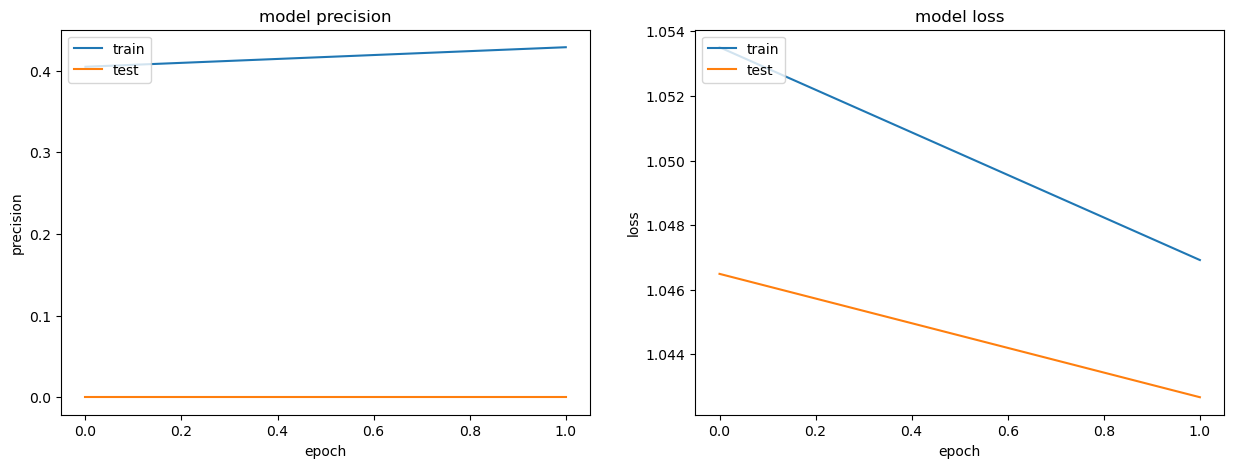

In [180]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_xformer_nb])
    
# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Unfortunately here after more than 40 hours of training I don't have much to show for my results. In retrospect a wiser approach would have been to sample my training and testing data to accelerate the training process. However, when I compare the Glove embeddings to numberbatch I can see that there was a depth of 50 with my glove selection and 300 with numberbatch. So a significant increase in training time was likely inevitable either way.

Had this turned out to yield some good results I could have statistically compared it to my best transformer model and then assessed the AUC of the ROC to determine if it truly performed better. 

## Takeaways

This is the first model I've trained for this course where I can say I believe my best performing model would be a viable option for my business case. If I were representing a PR firm trying to advise a government official or candidate on altering their message regarding Covid 19, I would trust a model that provided 80% precision that the sentiments were either negative, neutral or positive. And, I could confidently make a recommendation for action based on the precision of that model on the validation data.